In [1]:
#importing all libraries that are required
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import sklearn as sk
import math
import random
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter("ignore")

In [2]:
#reading csv data as dataframe
df = pd.read_csv('AER_credit_card_data.csv')

In [3]:
# droping features that are not requied
df.drop([ 'share', 'expenditure', 'dependents', 'majorcards', 'active'],axis=1,inplace=True)

#['card', 'reports', 'age', 'income', 'owner', 'selfemp', 'months']

# encoding categorical features to integers (integer encoding) 
df['card'] = df['card'].astype("category").cat.codes
df['owner']=df['owner'].astype("category").cat.codes
df['selfemp']=df['selfemp'].astype("category").cat.codes

# creating dictionary to get type of feature cat=categorical,num=numbercial
get_type = {'card':'cat', 'reports':'num', 'age':'num', 'income':'num', 'owner':'cat', 'selfemp':'cat', 'months':'num'}

#dictionary of list to store answer
ansers_knn= {'card':[], 'reports':[], 'age':[], 'income':[], 'owner':[], 'selfemp':[], 'months':[]}
ansers_wknn= {'card':[], 'reports':[], 'age':[], 'income':[], 'owner':[], 'selfemp':[], 'months':[]}
ansers_all= {'card':[], 'reports':[], 'age':[], 'income':[], 'owner':[], 'selfemp':[], 'months':[]}
df.describe()


,card,reports,age,income,owner,selfemp,months
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,0.775588,0.456406,33.213103,3.365376,0.440485,0.068992,55.267627
std,0.417353,1.345267,10.142783,1.693902,0.496634,0.253536,66.271746
min,0.000000,0.000000,0.166667,0.210000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,25.416670,2.243750,0.000000,0.000000,12.000000
50%,1.000000,0.000000,31.250000,2.900000,0.000000,0.000000,30.000000
75%,1.000000,0.000000,39.416670,4.000000,1.000000,0.000000,72.000000
max,1.000000,14.000000,83.500000,13.500000,1.000000,1.000000,540.000000


In [4]:
class KNN:
    
    def __init__(self,x_train,y_train,data_type,col_list,weights=False,dist='euc',K=1):
        # x_train = input features training dataset
        # y_train = output labels of training dataset
        # data_type - ['num','cat'] what is datatype of output label
        # weights = weights=True for weighted KNN
        # dist - ['euc','ham','chi'] which distance measure to use
        # K - value of K in KNN
        
        self.x_train = x_train
        self.y_train = y_train
        self.dist = dist
        self.K = K
        self.data_type =data_type
        self.weights = weights
        self.col_list =col_list
            
        if dist=='euc':
            self.dist = self.euclidian_dist
        elif dist=='chi':
            self.dist = self.chi_square_dist
        else:
            self.dist = self.hamming_dist
            
    def euclidian_dist(self,point1,point2):
        dist=0
        for m in range(len(point1)):
            dist+=  (point1[m]-point2[m])**2
        return math.sqrt(dist)

    def chi_square_dist(self,point1,point2):
        dist=0
        for m in range(len(point1)):
            if get_type[self.col_list[m]] == 'num':
                dist+= ((point1[m]-point2[m])**2) /(0.1+point1[m]+point2[m]) 
            else:
                dist+= 2*abs(point1[m]-point2[m]) 
        return dist/2.0
    
    def hamming_dist(self,point1,point2):
        dist=0
        for m in range(len(point1)):
            dist+=  abs(point1[m]-point2[m])
        
        return dist
    
    #defining weight
    def W(self,X):
        w= 1 if X==0.0 else 1/(X**2)
        return w
    
    #prectict label for given point p
    def predict(self,point):
        
        distances = []
        #iterate through all training data
        for p,i in zip(self.x_train,range(len(self.x_train))):
            # get distance according to selected distance measure
            d=self.dist(point,p)
            
            # append distance with label in list of tuples [(dist,label), ...] 
            distances.append((d,self.y_train[i]))
        
        #sort according to distance
        distances.sort()
        
        # if label to be predicted is numerical
        if self.data_type == 'num':
            dist_sum=0.0
            sum_w = 0.0
            
            # if we need to find weighted KNN 
            if self.weights ==True:
                for i in range(len(self.x_train)):
                    wi = self.W(distances[i][0])
                    dist_sum+=wi*distances[i][1]
                    sum_w += wi
                sum_w = round(sum_w,2)
                return round(dist_sum/sum_w,2) if sum_w > 0.01 else dist_sum 
            
            # if it is normal KNN 
            else:
                # take average of k neighbours
                for i in range(self.K):
                    dist_sum+=distances[i][1]
                return round(dist_sum/self.K,2)
        
        # else if label to be predicted is categorical
        else:
           
            #if we need to find weighted KNN 
            if self.weights ==True:
                lbs = {}
                for i in range(len(self.x_train)):
                    if distances[i][1] in lbs.keys():
                        lbs[distances[i][1]]+=self.W(distances[i][0])
                    else:
                        lbs[distances[i][1]]=self.W(distances[i][0])
                max_weight =0
                label_ans=0
                for label in lbs.keys():
                    if max_weight < lbs[label]:
                        max_weight = lbs[label]
                        label_ans = label
                return label_ans
                
            # if it is normal KNN
            else:
                # find the MODE(most occuring) of labels in nearest K neighbours
                lbs =[]
                for i in range(self.K):
                    lbs.append(distances[i][1])

                return stats.mode(lbs).mode[0]
    

In [5]:
# defining accuracy measure
def calculate_accuracy(y_true, y_pred, data_type):
    # if feature is numerical
    if data_type == 'num':
        return r2_score(y_true, y_pred)
    
    #if feature is catagorical
    else:
        return accuracy_score(y_true, y_pred)
    


N = len(df)


removal_percent_list = [0.05,0.10,0.20]
col_name_list = [ 'card', 'reports','age', 'income', 'owner', 'selfemp', 'months']


# removal_percent = 0.05
# col_name = 'income'
for col_name in col_name_list:
    feature_list = col_name_list.copy()
    feature_list.remove(col_name)
    for removal_percent in removal_percent_list:

        
        # calculate  num = removal_percent * total_rows
        num = int(np.rint(removal_percent * N))

        # genrate num ramdom interger in range [0,N)
        row_nums = random.sample(range(num),num)
        #row_nums = np.random.randint(0,N, size=(1,num))
        
        # make copy of dataframe so that maipulation are made on copy
        df_copy = df.copy()
        
        # replace actual values with NaN in the randomly genrated rows and store actual values in target_values list to
        # calculate accuracy later
        target_values = []
        for i in row_nums:
            target_values.append(df_copy[col_name][i])
            df_copy[col_name][i] = np.NaN
            
        # test data will contain rows without missing values
        test_data = df_copy[pd.isnull(df_copy[col_name])].copy()
        
        # test data will contain rows who have missing values
        train_data = df_copy[pd.isnull(df_copy[col_name])==False].copy()
        
        # split data into input feature and target values
        X_train = train_data.drop(col_name,axis=1).values
        Y_train = train_data[col_name].values
        
        # split data into input feature and target values
        X_test = test_data.drop(col_name,axis=1).values
        Y_test = np.ravel(np.array(target_values))
        
        for val_of_k in [1,7,'weighted']:
            
            for dist_mes in ['euc','ham','chi']:
                
                if val_of_k == 'weighted':
                    
                    val_K=5
                    weight = True
                    knn = KNN(X_train,Y_train,get_type[col_name],feature_list,dist=dist_mes,K=val_K,weights=weight)
                    Y_pred=[]
                    error =0
                    for i in range(len(X_test)):
                        y=knn.predict(X_test[i])
                        Y_pred.append(y)
                        error+=abs(y-Y_test[i])
                    
                    error = calculate_accuracy(Y_test,np.array(Y_pred),get_type[col_name])
                    print("Column Name : ",col_name,"Removal % :",removal_percent*100,"Weighted KNN :",weight,"Distance Measure : ",dist_mes,"Error : ",error)
                    ansers_wknn[col_name].append(error)
                    ansers_all[col_name].append(error)
                else:
                    
                    knn = KNN(X_train,Y_train,get_type[col_name],feature_list,dist=dist_mes,K=val_of_k)
                    Y_pred=[]
                    error =0
                    for i in range(len(X_test)):
                        y=knn.predict(X_test[i])
                        Y_pred.append(y)
                        error+=abs(y-Y_test[i])
                    
                    error = calculate_accuracy(Y_test,np.array(Y_pred),get_type[col_name])
                    print("Column Name : ",col_name,"Removal % :",removal_percent*100,"K : ",val_of_k,"Distance Measure : ",dist_mes,"Error : ",error)
                    ansers_knn[col_name].append(error)
                    ansers_all[col_name].append(error)
                

                
            
            
            
            


Column Name :  card Removal % : 5.0 K :  1 Distance Measure :  euc Error :  0.7121212121212122
Column Name :  card Removal % : 5.0 K :  1 Distance Measure :  ham Error :  0.696969696969697
Column Name :  card Removal % : 5.0 K :  1 Distance Measure :  chi Error :  0.696969696969697
Column Name :  card Removal % : 5.0 K :  7 Distance Measure :  euc Error :  0.7575757575757576
Column Name :  card Removal % : 5.0 K :  7 Distance Measure :  ham Error :  0.7575757575757576
Column Name :  card Removal % : 5.0 K :  7 Distance Measure :  chi Error :  0.7121212121212122
Column Name :  card Removal % : 5.0 Weighted KNN : True Distance Measure :  euc Error :  0.7727272727272727
Column Name :  card Removal % : 5.0 Weighted KNN : True Distance Measure :  ham Error :  0.7727272727272727
Column Name :  card Removal % : 5.0 Weighted KNN : True Distance Measure :  chi Error :  0.7575757575757576
Column Name :  card Removal % : 10.0 K :  1 Distance Measure :  euc Error :  0.6363636363636364
Column Name 

Column Name :  income Removal % : 5.0 K :  1 Distance Measure :  ham Error :  -1.2388855228372537
Column Name :  income Removal % : 5.0 K :  1 Distance Measure :  chi Error :  -1.5209817028943702
Column Name :  income Removal % : 5.0 K :  7 Distance Measure :  euc Error :  -0.16656290691661813
Column Name :  income Removal % : 5.0 K :  7 Distance Measure :  ham Error :  -0.22228281929331306
Column Name :  income Removal % : 5.0 K :  7 Distance Measure :  chi Error :  -0.3757835998005339
Column Name :  income Removal % : 5.0 Weighted KNN : True Distance Measure :  euc Error :  -0.13832998424280496
Column Name :  income Removal % : 5.0 Weighted KNN : True Distance Measure :  ham Error :  -0.15931023258519783
Column Name :  income Removal % : 5.0 Weighted KNN : True Distance Measure :  chi Error :  -0.7558746126095914
Column Name :  income Removal % : 10.0 K :  1 Distance Measure :  euc Error :  -0.6245201450418785
Column Name :  income Removal % : 10.0 K :  1 Distance Measure :  ham Erro

Column Name :  months Removal % : 5.0 K :  1 Distance Measure :  ham Error :  -1.2083543007877222
Column Name :  months Removal % : 5.0 K :  1 Distance Measure :  chi Error :  -1.2791463765242712
Column Name :  months Removal % : 5.0 K :  7 Distance Measure :  euc Error :  -0.4476679305489064
Column Name :  months Removal % : 5.0 K :  7 Distance Measure :  ham Error :  -0.42346485192525574
Column Name :  months Removal % : 5.0 K :  7 Distance Measure :  chi Error :  -0.11693024817348885
Column Name :  months Removal % : 5.0 Weighted KNN : True Distance Measure :  euc Error :  -0.23123892221653497
Column Name :  months Removal % : 5.0 Weighted KNN : True Distance Measure :  ham Error :  -0.19598695585710746
Column Name :  months Removal % : 5.0 Weighted KNN : True Distance Measure :  chi Error :  -0.4728479398177219
Column Name :  months Removal % : 10.0 K :  1 Distance Measure :  euc Error :  -1.3010508712930497
Column Name :  months Removal % : 10.0 K :  1 Distance Measure :  ham Erro

In [6]:

# l1 = ['Euclidian','Hamming','Chi Square']*6
# l2 = [['K=1']*3,['K=7']*3]*3
# l3 = [['5% Missing']*6,['10% Missing']*6,['20% Missing']*6]
# l2=list(np.ravel(np.array(l2)))
# l3=list(np.ravel(np.array(l3)))
# pd.DataFrame(ansers_knn,index=[l3,l2,l1])
#len(ansers_knn['card'])

In [7]:
# l1 = ['Euclidian','Hamming','Chi Square']*3
# l3 = [['5% Missing']*3,['10% Missing']*3,['20% Missing']*3]
# l3=list(np.ravel(np.array(l3)))
# pd.DataFrame(ansers_wknn,index=[l3,l1])

In [8]:

l1 = ['Euclidian','Hamming','Chi Square']*9
l2 = [['K=1']*3,['K=7']*3,['Weighted']*3]*3
l3 = [['5% Missing']*9,['10% Missing']*9,['20% Missing']*9]
l2=list(np.ravel(np.array(l2)))
l3=list(np.ravel(np.array(l3)))
tb=pd.DataFrame(ansers_all,index=[l3,l2,l1])
tb.to_csv('unscaled_imputation.csv')

In [9]:
print("Accuracy For each column with different methods (unscaled data)")
tb

Accuracy For each column with different methods (unscaled data)


card   reports       age    income  \
5% Missing  K=1      Euclidian   0.712121 -0.615685 -1.486324 -1.371215   
                     Hamming     0.696970 -0.487002 -1.373718 -1.238886   
                     Chi Square  0.696970 -2.560225 -1.418521 -1.520982   
            K=7      Euclidian   0.757576 -0.334480 -0.259481 -0.166563   
                     Hamming     0.757576 -0.253365 -0.273366 -0.222283   
                     Chi Square  0.712121 -0.960017 -0.579858 -0.375784   
            Weighted Euclidian   0.772727 -0.037318 -0.195530 -0.138330   
                     Hamming     0.772727 -0.035897 -0.250651 -0.159310   
                     Chi Square  0.757576 -0.554104 -0.973279 -0.755875   
10% Missing K=1      Euclidian   0.636364 -0.484593 -1.311537 -0.624520   
                     Hamming     0.651515 -0.416804 -1.307632 -0.510804   
                     Chi Square  0.659091 -1.779376 -1.107991 -0.512350   
            K=7      Euclidian   0.727273 -0.194020 -0.530158 -0.210778   
                     Hamming     0.734848 -0.266136 -0.501284 -0.200628   
                     Chi Square  0.674242 -1.029874 -0.449526 -0.127117   
            Weighted Euclidian   0.742424 -0.061446 -0.385300 -0.133708   
                     Hamming     0.742424 -0.086344 -0.411759 -0.133658   
                     Chi Square  0.696970 -0.581741 -0.741714 -0.200454   
20% Missing K=1      Euclidian   0.628788 -1.015107 -0.864226 -0.849052   
                     Hamming     0.636364 -0.607426 -0.833527 -0.737871   
                     Chi Square  0.666667 -0.940560 -0.842810 -0.852106   
            K=7      Euclidian   0.742424 -0.117468 -0.441897 -0.209407   
                     Hamming     0.761364 -0.120390 -0.426676 -0.196272   
                     Chi Square  0.712121 -0.391375 -0.393830 -0.192032   
            Weighted Euclidian   0.761364 -0.066948 -0.337286 -0.078308   
                     Hamming     0.765152 -0.068913 -0.363000 -0.097617   
                     Chi Square  0.715909 -0.362788 -0.496476 -0.381925   

                                    owner   selfemp    months  
5% Missing  K=1      Euclidian   0.515152  0.878788 -1.356763  
                     Hamming     0.500000  0.893939 -1.208354  
                     Chi Square  0.606061  0.893939 -1.279146  
            K=7      Euclidian   0.515152  0.939394 -0.447668  
                     Hamming     0.454545  0.939394 -0.423465  
                     Chi Square  0.500000  0.939394 -0.116930  
            Weighted Euclidian   0.590909  0.939394 -0.231239  
                     Hamming     0.606061  0.939394 -0.195987  
                     Chi Square  0.606061  0.924242 -0.472848  
10% Missing K=1      Euclidian   0.431818  0.886364 -1.301051  
                     Hamming     0.439394  0.893939 -1.399923  
                     Chi Square  0.446970  0.893939 -1.561143  
            K=7      Euclidian   0.477273  0.946970 -0.363239  
                     Hamming     0.492424  0.946970 -0.292300  
                     Chi Square  0.469697  0.946970 -0.349697  
            Weighted Euclidian   0.530303  0.946970 -0.184880  
                     Hamming     0.530303  0.946970 -0.202433  
                     Chi Square  0.477273  0.939394 -0.566266  
20% Missing K=1      Euclidian   0.530303  0.893939 -2.045866  
                     Hamming     0.537879  0.905303 -2.233545  
                     Chi Square  0.496212  0.878788 -2.812412  
            K=7      Euclidian   0.541667  0.939394 -0.707552  
                     Hamming     0.549242  0.939394 -0.716553  
                     Chi Square  0.553030  0.939394 -0.749684  
            Weighted Euclidian   0.594697  0.939394 -0.409433  
                     Hamming     0.579545  0.939394 -0.393060  
                     Chi Square  0.511364  0.928030 -1.215847

In [10]:
#for plotting bar graph

def plot_bar_x(no_movies,label,col_n):
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, no_movies)
    plt.xlabel('Accuracy', fontsize=5)
    plt.ylabel('method', fontsize=5)
    plt.xticks(index, label, fontsize=5, rotation=30)
    plt.title('Accuracy for '+ col_n)
    plt.show()
    
y_Ax =["5% Missing,K=1,Euclidian,"
,"5% Missing,K=1,Hamming,"
,"5% Missing,K=1,Chi Square,"
,"5% Missing,K=7,Euclidian,"
,"5% Missing,K=7,Hamming,"
,"5% Missing,K=7,Chi Square,"
,"5% Missing,Weighted,Euclidian,"
,"5% Missing,Weighted,Hamming,"
,"5% Missing,Weighted,Chi Square,"
,"10% Missing,K=1,Euclidian,"
,"10% Missing,K=1,Hamming,"
,"10% Missing,K=1,Chi Square,"
,"10% Missing,K=7,Euclidian,"
,"10% Missing,K=7,Hamming,"
,"10% Missing,K=7,Chi Square,"
,"10% Missing,Weighted,Euclidian,"
,"10% Missing,Weighted,Hamming,"
,"10% Missing,Weighted,Chi Square,"
,"20% Missing,K=1,Euclidian,"
,"20% Missing,K=1,Hamming,"
,"20% Missing,K=1,Chi Square,"
,"20% Missing,K=7,Euclidian,"
,"20% Missing,K=7,Hamming,"
,"20% Missing,K=7,Chi Square,"
,"20% Missing,Weighted,Euclidian,"
,"20% Missing,Weighted,Hamming,"
,"20% Missing,Weighted,Chi Square,"]


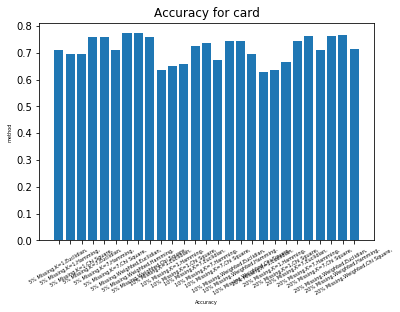

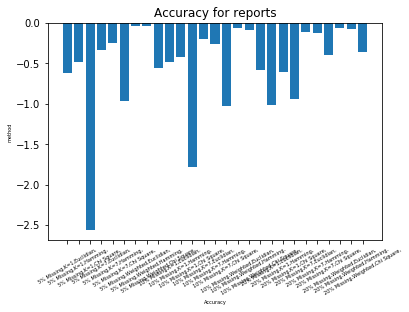

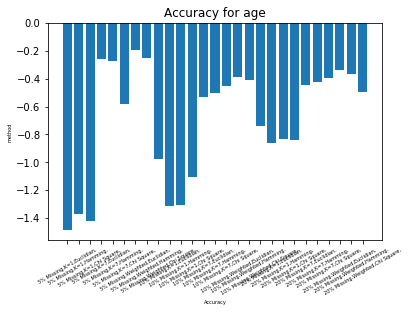

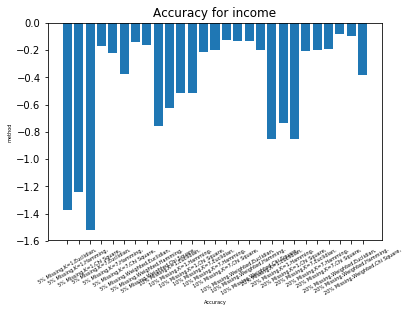

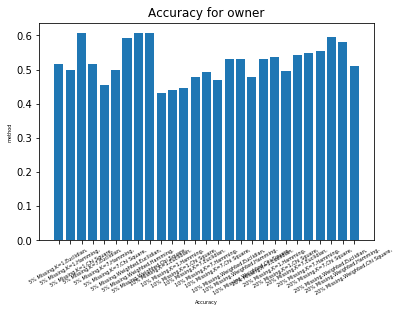

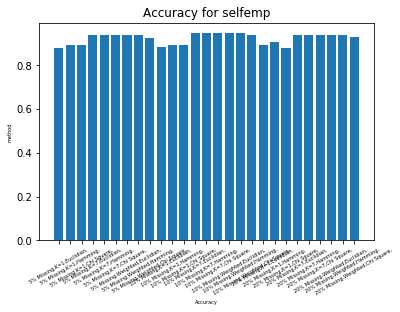

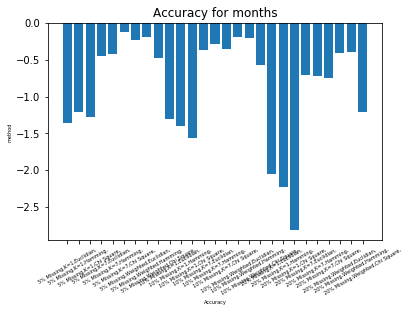

In [11]:
#plotting accurracy for each column with different combinations
for col_n in col_name_list:    
    plot_bar_x(ansers_all[col_n],y_Ax,col_n)